In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rkstiff.grids import construct_x_Dx_cheb
from rkstiff.etd35 import ETD35
from rkstiff.etd34 import ETD34
from rkstiff.if34 import IF34
import time

In [2]:
N = 20
epsilon = 0.01
x,D = construct_x_Dx_cheb(N,-1,1)
D2 = D.dot(D)
L = epsilon*D2 + np.eye(*D2.shape)
L = L[1:-1,1:-1] # Interior points

def NL(u):
    return x[1:-1] - np.power(u+x[1:-1],3)

u0 = 0.53*x + 0.47*np.sin(-1.5*np.pi*x)
w0 = u0 - x

solver34 = ETD34(linop=L,NLfunc=NL,epsilon=1e-4,contour_points=64,contour_radius=20)
solver35 = ETD35(linop=L,NLfunc=NL,epsilon=1e-4,contour_points=64,contour_radius=20)
solverIF = IF34(linop=L,NLfunc=NL,epsilon=1e-4,contour_points=64,contour_radius=20)
solverDiag34 = ETD34(linop=L,NLfunc=NL,epsilon=1e-4,contour_points=32,contour_radius=1,diagonalize=True)
solverDiag35 = ETD35(linop=L,NLfunc=NL,epsilon=1e-4,contour_points=32,contour_radius=1,diagonalize=True)
solverDiagIF34 = IF34(linop=L,NLfunc=NL,epsilon=1e-4,contour_points=32,contour_radius=1,diagonalize=True)
solvers = [solver34,solver35,solverIF,solverDiag34,solverDiag35,solverDiagIF34]
titles = ['ETD34','ETD35','IF34','ETD34 Diagonalized','ETD35 Diagonalized','IF34 Diagonalized']

In [3]:
Xvec,Tvec,Uvec = [],[],[]
for solver in solvers:   
    _ = solver.evolve(w0[1:-1],t0=0,tf=100)
    U = []
    for wint in solver.u:
        w = np.r_[0,wint.real,0]
        u = w + x
        U.append(u)
    U = np.array(U)
    t = np.array(solver.t)
    T,X = np.meshgrid(t,x,indexing='ij')
    Xvec.append(X); Tvec.append(T); Uvec.append(U)

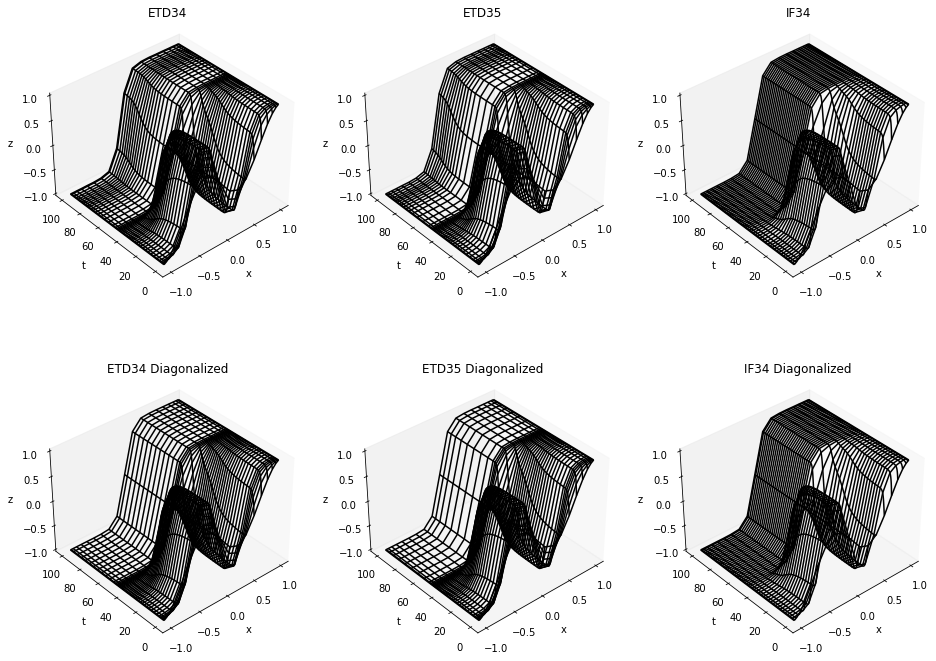

In [4]:
fig = plt.figure(figsize=(16,12))
for i in range(6):
    ax = fig.add_subplot(2,3,i+1,projection='3d')
    ax.plot_wireframe(Xvec[i],Tvec[i],Uvec[i],color='black')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('z')
    ax.set_facecolor('white')
    ax.grid(False)
    ax.set_title(titles[i])
    ax.view_init(elev=36,azim=-131)
# fig.tight_layout()

In [5]:
start = time.time()
solver = ETD34(linop=L,NLfunc=NL,epsilon=1e-4,contour_points=64,contour_radius=20)
_ = solver.evolve(w0[1:-1],t0=0,tf=100,store_data=False)
end = time.time()
print(titles[0],'-> {:.2e}'.format(end-start))

start = time.time()
solver = ETD35(linop=L,NLfunc=NL,epsilon=1e-4,contour_points=64,contour_radius=20)
_ = solver.evolve(w0[1:-1],t0=0,tf=100,store_data=False)
end = time.time()
print(titles[1],'-> {:.2e}'.format(end-start))

start = time.time()
solver = IF34(linop=L,NLfunc=NL,epsilon=1e-4,contour_points=64,contour_radius=20)
_ = solver.evolve(w0[1:-1],t0=0,tf=100,store_data=False)
end = time.time()
print(titles[2],'-> {:.2e}'.format(end-start))

start = time.time()
solverDiag = ETD34(linop=L,NLfunc=NL,epsilon=1e-4,contour_points=32,contour_radius=1,diagonalize=True)
_ = solver.evolve(w0[1:-1],t0=0,tf=100,store_data=False)
end = time.time()
print(titles[3],'-> {:.2e}'.format(end-start))

start = time.time()
solver = ETD35(linop=L,NLfunc=NL,epsilon=1e-4,contour_points=32,contour_radius=1,diagonalize=True)
_ = solver.evolve(w0[1:-1],t0=0,tf=100,store_data=False)
end = time.time()
print(titles[4],'-> {:.2e}'.format(end-start))

start = time.time()
solver = IF34(linop=L,NLfunc=NL,epsilon=1e-4,contour_points=32,contour_radius=1,diagonalize=True)
_ = solver.evolve(w0[1:-1],t0=0,tf=100,store_data=False)
end = time.time()
print(titles[5],'-> {:.2e}'.format(end-start))

ETD34 -> 2.92e-01
ETD35 -> 6.59e-01
IF34 -> 5.80e-02
ETD34 Diagonalized -> 5.90e-02
ETD35 Diagonalized -> 5.60e-02
IF34 Diagonalized -> 6.10e-02


In [6]:
%%timeit
solver = IF34(linop=L,NLfunc=NL,epsilon=1e-4,contour_points=32,contour_radius=1,diagonalize=True)
_ = solver.evolve(w0[1:-1],t0=0,tf=100,store_data=False)

59.6 ms ± 72.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%%timeit
solver = IF34(linop=L,NLfunc=NL,epsilon=1e-4,contour_points=64,contour_radius=20)
_ = solver.evolve(w0[1:-1],t0=0,tf=100,store_data=False)

57.5 ms ± 75.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
